# Menu <a class="anchor" id="menu"></a>
* [1. Feature Engineering](#feature_engineering)
* [2. Préparation du jeu de données](#models_prepare)
* [3. Améliorer les modèles avec de `nouvelles features`](#models_feature_engineering)
    * [3.1 Logistic Regression](#models_linear_new_features)
    * [3.2 XGBoost Classifier](#models_xgboost_new_features)
* [4. Optimizer le modèle avec une `features selection`](#models_feature_selection)
    * [4.1 Logistic Regression](#models_linear_features_selection)
    * [4.2 XGBoost Classifier](#models_xgboost_features_selection)
* [5. Optimizer le modèle avec une `mesure adaptée`](#models_new_metrics)
    * [5.0 Création d'une mesure adaptée](#custom_metric)
    * [5.1 Logistic Regression](#models_linear_new_metrics)
    * [5.2 XGBoost Classifier](#models_xgboost_new_metrics)

# Mise en place

### Chargeons les librairies utiles

In [1]:
import time
import copy as cp
from collections import defaultdict
from zipfile import ZipFile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly_express as px

np.random.seed(0) # Seed the unexpected randomness of this world

### Chargons le jeu de données

In [2]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [3]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    #usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_train.shape

(307511, 122)

### Faisons quelques réglages pour mieux voir les DataFrames pandas

In [4]:
pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

### Réduisons la taille du jeu de données pour les essais préliminaires des différents modèles

In [5]:
sample_size_base = 30000
sample_size_grid = 30000
data_work = data_application_train[:sample_size_base].copy()

In [6]:
data_work.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,False,True,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",False,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,False,False,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,False,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,True,True,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# Créons de `nouvelles features` métiers <a class="anchor" id="feature_engineering"></a> [⇪](#menu)

### Quelle fraction du bien convointé représente le montant du crédit ?

In [7]:
data_work['FRAC_GOODS_PRICE'] = data_work.AMT_CREDIT / data_work.AMT_GOODS_PRICE

In [8]:
data_work[['AMT_CREDIT','AMT_GOODS_PRICE','FRAC_GOODS_PRICE']].head()

,AMT_CREDIT,AMT_GOODS_PRICE,FRAC_GOODS_PRICE
0,406597.5,351000.0,1.158397
1,1293502.5,1129500.0,1.145199
2,135000.0,135000.0,1.000000
3,312682.5,297000.0,1.052803
4,513000.0,513000.0,1.000000


### Quel age (en années) avait le client quand il a obtenu son emploi actuel ?

In [9]:
data_work['AGE_EMPLOYEMENT'] = (data_work.DAYS_BIRTH - data_work.DAYS_EMPLOYED) / -365

In [10]:
data_work[['DAYS_BIRTH','DAYS_EMPLOYED','AGE_EMPLOYEMENT']].head()

,DAYS_BIRTH,DAYS_EMPLOYED,AGE_EMPLOYEMENT
0,-9461,-637,24.175342
1,-16765,-1188,42.676712
2,-19046,-225,51.564384
3,-19005,-3039,43.742466
4,-19932,-3038,46.284932


### Quel montant de revenu est disponible pour chaque membre de la famille ?

In [11]:
data_work['INCOME_PER_FAM_MEMBER'] = data_work.AMT_INCOME_TOTAL / data_work.CNT_FAM_MEMBERS

In [12]:
data_work[['AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','INCOME_PER_FAM_MEMBER']].head()

,AMT_INCOME_TOTAL,CNT_FAM_MEMBERS,INCOME_PER_FAM_MEMBER
0,202500.0,1.0,202500.0
1,270000.0,2.0,135000.0
2,67500.0,1.0,67500.0
3,135000.0,2.0,67500.0
4,121500.0,1.0,121500.0


### Combien de demandes de crédits ont été faites au total ?

In [13]:
data_work['AMT_REQ_CREDIT_BUREAU_TOTAL'] =  data_work.AMT_REQ_CREDIT_BUREAU_HOUR +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_DAY +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_WEEK +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_MON +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_QRT +\
                                            data_work.AMT_REQ_CREDIT_BUREAU_YEAR

In [14]:
data_work[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','AMT_REQ_CREDIT_BUREAU_TOTAL']].head()

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_REQ_CREDIT_BUREAU_TOTAL
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Title TODO

In [15]:
data_work['ANNUITY_INCOME_RATIO'] = data_work.AMT_INCOME_TOTAL / data_work.AMT_ANNUITY

### Title TODO

In [16]:
data_work['DIFF_GOOD_PRICE_CREDIT'] = data_work.AMT_GOODS_PRICE - data_work.AMT_CREDIT

### Title TODO

In [17]:
data_work['AGE_INT'] = data_work.DAYS_BIRTH / -365

### Ajoutons les nouvelles features au jeu de données

In [18]:
data_work2 = data_work.copy()

In [19]:
data_work2['FRAC_GOODS_PRICE'] = data_work['FRAC_GOODS_PRICE']
data_work2['AGE_EMPLOYEMENT'] = data_work['AGE_EMPLOYEMENT']
data_work2['INCOME_PER_FAM_MEMBER'] = data_work['INCOME_PER_FAM_MEMBER']
data_work2['AMT_REQ_CREDIT_BUREAU_TOTAL'] = data_work['AMT_REQ_CREDIT_BUREAU_TOTAL']

data_work2['ANNUITY_INCOME_RATIO'] = data_work['ANNUITY_INCOME_RATIO']
data_work2['DIFF_GOOD_PRICE_CREDIT'] = data_work['DIFF_GOOD_PRICE_CREDIT']
data_work2['AGE_INT'] = data_work['AGE_INT']

### Vérifions la corrélation linéaire des nouvelles variables avec TARGET

In [20]:
correlations = data_work2.corr(method='pearson')

In [21]:
new_features = [
    'FRAC_GOODS_PRICE', 
    'AGE_EMPLOYEMENT', 
    'INCOME_PER_FAM_MEMBER', 
    'AMT_REQ_CREDIT_BUREAU_TOTAL', 
    'ANNUITY_INCOME_RATIO', 
    'DIFF_GOOD_PRICE_CREDIT', 
    'AGE_INT'
]

corr_target = correlations.TARGET.sort_values(ascending=False)
for i, (key, value) in enumerate(corr_target.iteritems()):
    if key in new_features:
        print(f"{key.rjust(40)} : {value:6.4f}")

                        FRAC_GOODS_PRICE : 0.0636
             AMT_REQ_CREDIT_BUREAU_TOTAL : 0.0187
                    ANNUITY_INCOME_RATIO : 0.0145
                   INCOME_PER_FAM_MEMBER : 0.0139
                  DIFF_GOOD_PRICE_CREDIT : -0.0240
                         AGE_EMPLOYEMENT : -0.0406
                                 AGE_INT : -0.0809


# Préparons le jeu de données <a class="anchor" id="models_prepare"></a> [⇪](#menu)

Nous allons utiliser exactement la même approche que lors du Spot Checking des models *(02_Spot_cheking_models.ipynb)*.

### Découpage du jeu de données  <a class="anchor" id="models_prepare_split"></a> [⇪](#menu)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_full = data_work2.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_work2['TARGET']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.15,
                                                random_state=0,
                                                stratify=Y_full)

In [25]:
print(f"X_train: {X_train.shape[0] / X_full.shape[0] * 100}% | X_test: {X_test.shape[0] / X_full.shape[0]* 100}%")

X_train: 85.0% | X_test: 15.0%


### Encodage des données non-numériques <a class="anchor" id="models_prepare_encode"></a> [⇪](#menu)

In [26]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder #, LabelEncoder

In [214]:
def fit_labels(data):
    """ Prepare the encoder for the categorical columns.
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    # Define columns
    oe_targets = [x for x in ['NAME_EDUCATION_TYPE', 'WEEKDAY_APPR_PROCESS_START'] if x in data.columns]
    ohe_targets = [x for x in data.select_dtypes(exclude='number').columns if x not in oe_targets]
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_model):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

In [28]:
oe_model, ohe_model = fit_labels(X_train)

In [29]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations des données manquantes <a class="anchor" id="models_prepare_impute"></a> [⇪](#menu)

In [30]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [31]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=0, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    
    return dt

In [32]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

In [33]:
X_train = impute(X_train, imputer_model)
X_test = impute(X_test, imputer_model)

### Normalisation du jeu de données <a class="anchor" id="models_prepare_normalize"></a> [⇪](#menu)

In [34]:
from sklearn.preprocessing import MinMaxScaler

In [35]:
def fit_normalizer(data):
       
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    return scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

In [36]:
model_scaler = fit_normalizer(X_train)

In [37]:
X_train = normalize(X_train, model_scaler)
X_test = normalize(X_test, model_scaler)

### Définissons quelques fonctions pour faciliter la gestion des scores *(rapports, graphiques, enregistrement)* <a class="anchor" id="models_prepare_metrics"></a> [⇪](#menu)

In [38]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, average_precision_score

In [39]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---".ljust(100,'-'),"\n\n", report)

In [40]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---".ljust(100,'-'),"\n")
    plt.show()

In [41]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- ROC AUC ---".ljust(100,'-'),"\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            roc_score = roc_auc_score(y_true, y_pred)
            sorted_scores[model_name] = roc_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)
    
    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [42]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- PRECISION RECALL AUC ---".ljust(100,'-'), "\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            pr_score = average_precision_score(y_true, y_pred)
            sorted_scores[model_name] = pr_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)

    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.3)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [43]:
def save_score(method_name, threshold, param_grid, training_time, inference_time, **scores):
    
    idx = np.where(scores_df.Method == method_name)[0]        
    idx = idx[0] if idx.size > 0 else len(scores_df.index)
    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
    TP = scores.get('TP', None)
    FP = scores.get('FP', None)
    TN = scores.get('TN', None)
    FN = scores.get('FN', None)
    
    scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]    
    scores_df.to_csv(scores_path, index=False)

In [226]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores_tuning.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, **scores):
    
    if X_ref is None:
        X_ref = X_test
        
    if y_ref is None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])

    scores = {
        'roc_auc': roc_auc_score(y_ref, y_pred_proba),
        'f1': f1_score(y_ref, y_pred),
        'accuracy': accuracy_score(y_ref, y_pred),
        'precision': precision_score(y_ref, y_pred, zero_division=0),
        'recall': recall_score(y_ref, y_pred),
        'average_precision': average_precision_score(y_ref, y_pred_proba),
        'TN': cm[0][0],
        'FP': cm[0][1],
        'FN': cm[1][0],
        'TP': cm[1][1],
    }
    
    # Register score and replace if it already exists
    if register:
        save_score(method_name, threshold, param_grid, training_time, inference_time, **scores)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64 and key not in ['TP','TN','FP','FN']:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
            
    print('-'*100,f'These information are based on the best estimator of the above cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    print(f"--- {method_name} ---".ljust(100,'-'),"\n\n",scores_str, sep="")
          
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)
        print_prauc(y_ref, y_preds)

In [45]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [46]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [47]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV # --> trop lent


def fit_model(model_name, model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2, register=True):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    fit_time = time.perf_counter()
    grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=0)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = f"{scoring.upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{scoring.upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")
            
        print("\n", f"".center(100,'-'), sep='')
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid} #, **scores_args}

In [48]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

#### Let's define the cross-validation method

In [49]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [50]:
import FreeMobileSMS as sms
sms.send("Data preparation done", stop=False)

# Testons les modèles sélectionnés avec les nouvelles features<a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

--- 
>#### Voici pour rappel les deux modèles que l'on a choisi d'essayer d'améliorer:
> - la `Balanced LogisticRegression`:
>   - ROC_AUC : 0.7309
>   - F1 : 0.2433
>   - ACCURACY : 0.6751
>   - PRECISION : 0.1495
>   - RECALL : 0.6528
>   - AVERAGE_PRECISION : 0.2002
> - le `Balanced XGBClassifier`:
>   - ROC_AUC : 0.7221
>   - F1 : 0.2448
>   - ACCURACY : 0.6833
>   - PRECISION : 0.1513
>   - RECALL : 0.6417
>   - AVERAGE_PRECISION : 0.2061

---

## 1. Logistic Regression <a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [53]:
model_name = "Balanced LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5058
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6426
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6225
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6100
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6293

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6020 (std:0.0598)

----------------------------------------------------------------------------------------------------


In [54]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

In [227]:
get_scores(f"{model_name} [w/features]", **grd_log, register=True)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- AMT_REQ_CREDIT_BUREAU_HOUR
- AMT_REQ_CREDIT_BUREAU_WEEK
- APARTMENTS_MEDI
- BASEMENTAREA_AVG
- BASEMENTAREA_MEDI
- ...
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 245 features, but LogisticRegression is expecting 69 features as input.

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [56]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23008727922479555) for this model is reached with a threshold of 0.402


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/thresholding & features] ----------------------------------------

             ROC_AUC : 0.7320
                  F1 : 0.2143
            ACCURACY : 0.5438
           PRECISION : 0.1243
              RECALL : 0.7778
   AVERAGE_PRECISION : 0.2026

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.52      0.68      4140
Prediction = 1       0.12      0.78      0.21       360

      accuracy                           0.54      4500
     macro avg       0.54      0.65      0.45      4500
  weighted avg       0.90  

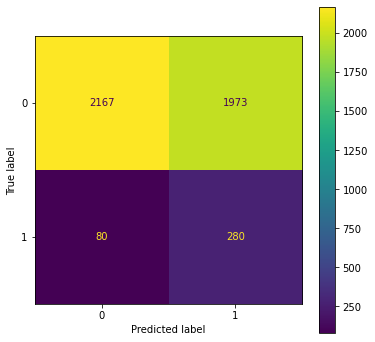

In [57]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

## 2. Balanced XGBoost Classifier Grid + extra features<a class="anchor" id="models_xgboost_new_features"></a> [⇪](#menu)

In [58]:
from xgboost import XGBClassifier

In [59]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [60]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [61]:
model_name = "Balanced XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6522
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6759
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7140
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6481
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6989

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6778 (std:0.0443)

----------------------------------------------------------------------------------------------------


In [62]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 60,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/features] ------------------------------------------------------------

             ROC_AUC : 0.7242
                  F1 : 0.2437
            ACCURACY : 0.6773
           PRECISION : 0.1500
              RECALL : 0.6500
   AVERAGE_PRECISION : 0.2036

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

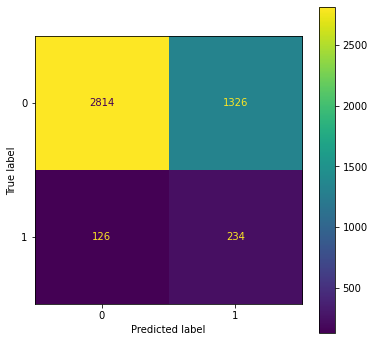

--- ROC AUC ---------------------------------------------------------------------------------------- 



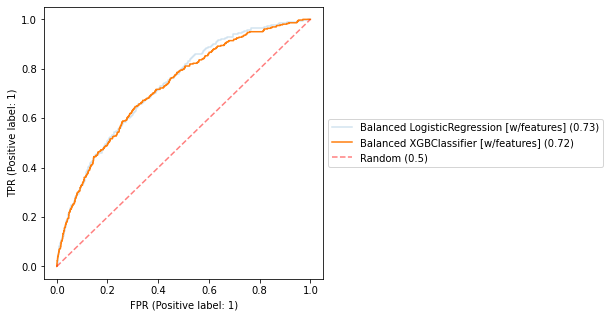

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



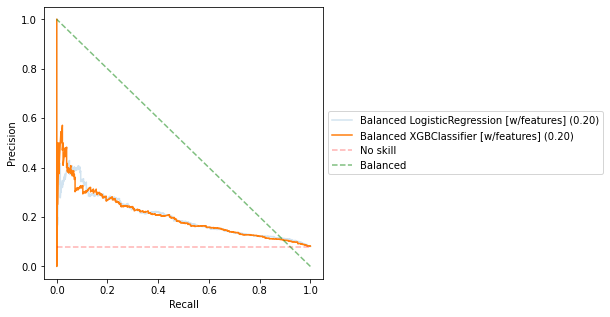

In [63]:
get_scores(f"{model_name} [w/features]", **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [64]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.1981196491412364) for this model is reached with a threshold of 0.34900000000000003


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/thresholding & features] ---------------------------------------------

             ROC_AUC : 0.7242
                  F1 : 0.1894
            ACCURACY : 0.3873
           PRECISION : 0.1059
              RECALL : 0.8944
   AVERAGE_PRECISION : 0.2036

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.34      0.51      4140
Prediction = 1       0.11      0.89      0.19       360

      accuracy                           0.39      4500
     macro avg       0.54      0.62      0.35      4500
  weighted avg       0.90  

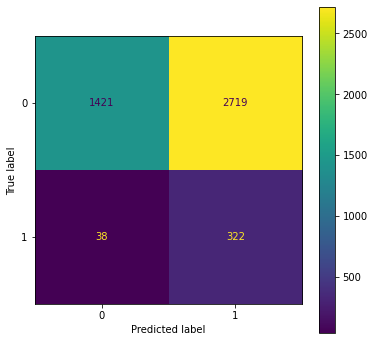

In [65]:
get_scores(f"{model_name} [w/thresholding & features]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

## 3. Revue des scores <a class="anchor" id="models_new_features_scores"></a> [⇪](#menu)

In [66]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
0,Balanced LogisticRegression [w/features],0.732030,0.245559,0.151223,0.652778
2,Balanced XGBClassifier [w/features],0.724231,0.243750,0.150000,0.650000


In [67]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
1,Balanced LogisticRegression [w/thresholding & ...,0.732030,0.214313,0.124279,0.777778
3,Balanced XGBClassifier [w/thresholding & featu...,0.724231,0.189356,0.105886,0.894444


#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [68]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
21,Balanced LogisticRegression,0.730879,0.243271,0.149491,0.652778
22,Balanced LogisticRegression [w/thresholding],0.730879,0.228700,0.136364,0.708333
27,Balanced XGBClassifier,0.722080,0.244833,0.151277,0.641667
28,Balanced XGBClassifier [w/thresholding],0.722080,0.180033,0.099819,0.916667


>>>> Dois je garder le même notebook et dataset et simplement ajouter les nouvelles features à l'ancien dataset pour obtenir des résultats constants / comparables ?

# Feature selection

## Select without model

In [69]:
from sklearn.feature_selection import SelectKBest, chi2

In [70]:
selector2 = SelectKBest(chi2, k=5).fit(X_train, y_train)

In [71]:
X_train.columns[selector2.get_support()]

Index(['NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M',
       'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3'],
      dtype='object')

## Recursive feature elimination with cross-validation

In [72]:
from sklearn.feature_selection import RFECV

In [73]:
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=grd_log['model'],
    step=1,
    cv=skfold,
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
      estimator=LogisticRegression(C=0.1, class_weight='balanced',
                                   max_iter=3000, random_state=0,
                                   solver='liblinear'),
      scoring='roc_auc')

Optimal number of features : 88


/home/valkea/Dev/OpenClassrooms/Projets_AI/P4/venvP4/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


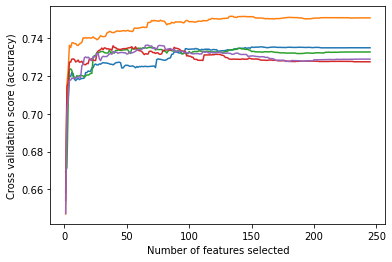

In [74]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [75]:
rfecv.n_features_

88

In [76]:
selected_cols = X_train.columns[rfecv.get_support()]
selected_cols

Index(['NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M',
       'FLAG_OWN_CAR_True', 'NAME_TYPE_SUITE_Group of people',
       'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B',
       'NAME_TYPE_SUITE_nan', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_Municipal apartment', 'OCCUPATION_TYPE_Drivers',
       'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_IT staff',
       'OCCUPATION_TYPE_Low-skill Laborers',
       'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Secretaries',
       'ORGANIZATION_TYPE_Bank', 'ORGANIZATION_TYPE_Culture',
       'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Hotel',
       'ORGANIZATION_TYPE_Industry: type 11',
       'ORGANIZATION_TYPE_Industry: type 2',
       'ORGANIZATION_TYPE_Industry: type 5',
       'ORGANIZATION_TYPE_Industry: type 9',
       'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Military',
       'ORGANIZATION_TYPE_Police', 'ORGANIZA

In [77]:
X_train[selected_cols].shape

(25500, 88)

## 1. Logistic Regression <a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [80]:
model_name = "Balanced LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    X_ref=X_train[selected_cols],
    y_ref=y_train,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6536
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6211
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6150
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6690
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7040

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6526 (std:0.0475)

----------------------------------------------------------------------------------------------------


In [81]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/features & selection] -------------------------------------------

             ROC_AUC : 0.7324
                  F1 : 0.2427
            ACCURACY : 0.6769
           PRECISION : 0.1494
              RECALL : 0.6472
   AVERAGE_PRECISION : 0.2002

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

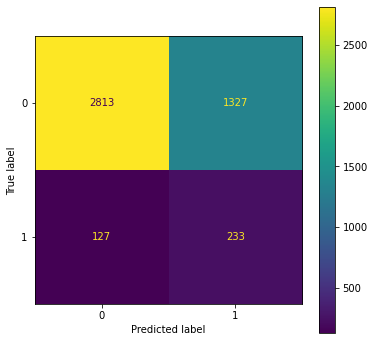

--- ROC AUC ---------------------------------------------------------------------------------------- 



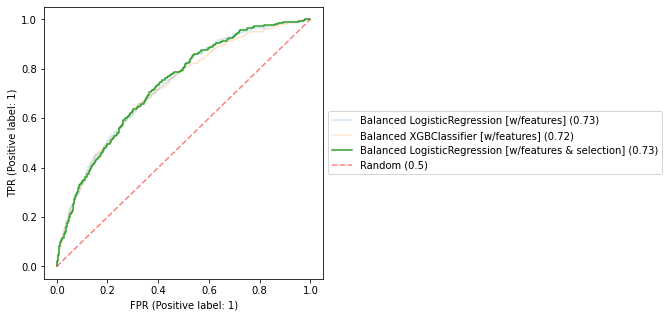

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



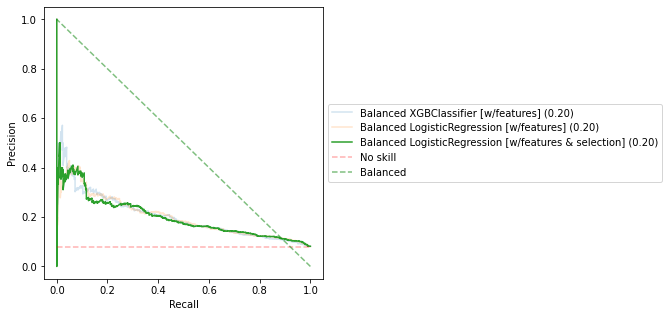

In [82]:
get_scores(f"{model_name} [w/features & selection]", **grd_log, X_ref=X_test[selected_cols], register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [83]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train[selected_cols], y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23963963963963963) for this model is reached with a threshold of 0.432


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/thresholding & features & selection] ----------------------------

             ROC_AUC : 0.7324
                  F1 : 0.2273
            ACCURACY : 0.5829
           PRECISION : 0.1334
              RECALL : 0.7667
   AVERAGE_PRECISION : 0.2002

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.57      0.71      4140
Prediction = 1       0.13      0.77      0.23       360

      accuracy                           0.58      4500
     macro avg       0.55      0.67      0.47      4500
  weighted avg       0.90  

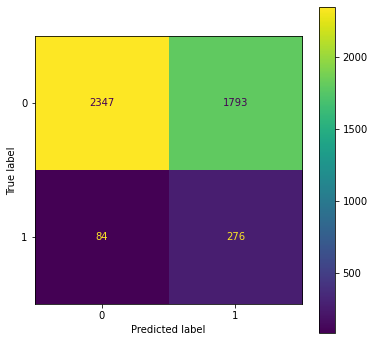

In [84]:
get_scores(f"{model_name} [w/thresholding & features & selection]", **grd_log, threshold=best_threshold, X_ref=X_test[selected_cols], register=True, show_roccurves=False)

## 2. Balanced XGBoost Classifier Grid + extra features<a class="anchor" id="models_xgboost_new_features"></a> [⇪](#menu)

In [85]:
from xgboost import XGBClassifier

In [86]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [87]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [88]:
model_name = "Balanced XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    X_ref=X_train[selected_cols],
    y_ref=y_train,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6161
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6721
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7092
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6883
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5880

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6548 (std:0.0555)

----------------------------------------------------------------------------------------------------


In [89]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.05,
 'max_depth': 2,
 'n_estimators': 140,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/features & selection] ------------------------------------------------

             ROC_AUC : 0.7247
                  F1 : 0.2373
            ACCURACY : 0.6729
           PRECISION : 0.1459
              RECALL : 0.6361
   AVERAGE_PRECISION : 0.2099

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.79      4140
Prediction = 1       0.15      0.64      0.24       360

      accuracy                           0.67      4500
     macro avg       0.55      0.66      0.51      4500
  weighted avg       0.89  

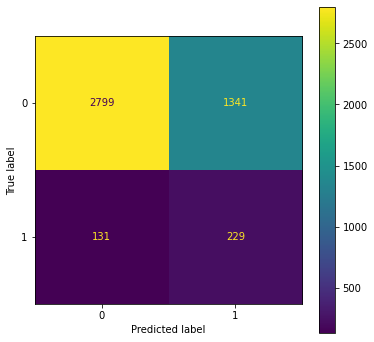

--- ROC AUC ---------------------------------------------------------------------------------------- 



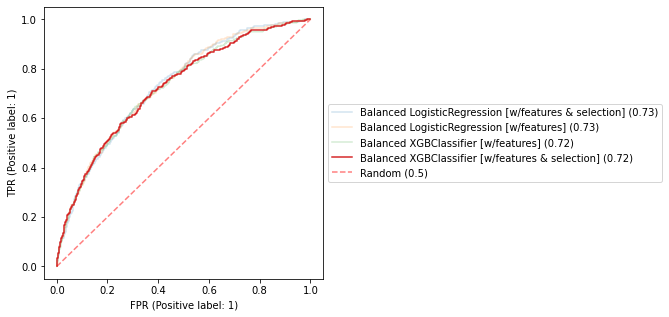

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



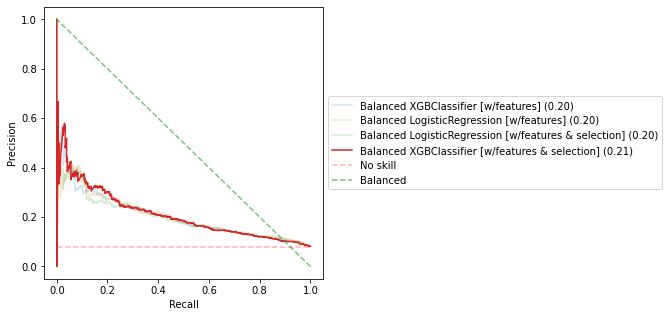

In [ ]:
get_scores(f"{model_name} [w/features & selection]", **grd_xgb, X_ref=X_test[selected_cols], register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [ ]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train[selected_cols], y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.20931833830617397) for this model is reached with a threshold of 0.371


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/thresholding & features & selection] ---------------------------------

             ROC_AUC : 0.7247
                  F1 : 0.1978
            ACCURACY : 0.4429
           PRECISION : 0.1118
              RECALL : 0.8583
   AVERAGE_PRECISION : 0.2099

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.41      0.57      4140
Prediction = 1       0.11      0.86      0.20       360

      accuracy                           0.44      4500
     macro avg       0.54      0.63      0.39      4500
  weighted avg       0.90  

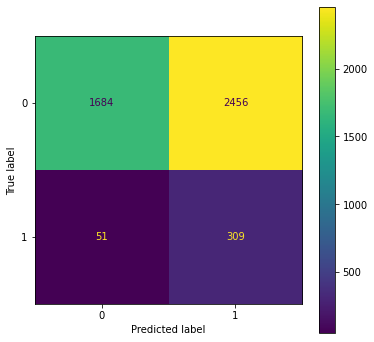

In [ ]:
get_scores(f"{model_name} [w/thresholding & features & selection]", **grd_xgb, threshold=best_threshold, X_ref=X_test[selected_cols], register=True, show_roccurves=False)

## 3. Revue des scores <a class="anchor" id="models_new_features_scores"></a> [⇪](#menu)

In [104]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
0,Balanced LogisticRegression [w/features],0.732030,0.245559,0.151223,0.652778
2,Balanced XGBClassifier [w/features],0.724231,0.243750,0.150000,0.650000
4,Balanced LogisticRegression [w/features & sele...,0.732358,0.242708,0.149359,0.647222
6,Balanced XGBClassifier [w/features & selection],0.724667,0.237306,0.145860,0.636111


In [225]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

AttributeError: 'DataFrame' object has no attribute 'Method'

#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [ ]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
21,Balanced LogisticRegression,0.730879,0.243271,0.149491,0.652778
22,Balanced LogisticRegression [w/thresholding],0.730879,0.228700,0.136364,0.708333
27,Balanced XGBClassifier,0.722080,0.244833,0.151277,0.641667
28,Balanced XGBClassifier [w/thresholding],0.722080,0.180033,0.099819,0.916667


In [ ]:
import FreeMobileSMS as sms
sms.send()

JupyterScriptCompleted: Jupyter is waiting

## Selection methode champion

In [184]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [185]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

import gc
gc.enable()

In [186]:
data = data_work2.copy()

categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')

In [187]:
data.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'FRAC_GOODS_PRICE', 'AGE_EMPLOYEMENT',
       'INCOME_PER_FAM_MEMBER', 'AMT_REQ_CREDIT_BUREAU_TOTAL',
       'ANNUITY_INCOME_RATIO', 'DIFF_GOOD_PRICE_CREDIT', 'AGE_INT'],
      dtype='object', length=129)

#### Build the benchmark for feature importance

In [188]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4,
        'verbose':-1
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats, verbose_eval=-1)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [189]:
# Seed the unexpected randomness of this world
np.random.seed(123)

# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

- “split” contains numbers of times the feature is used in a model.
- “gain”, contains total gains of splits which use the feature.

In [190]:
actual_imp_df

,feature,importance_gain,importance_split,trn_score
0,NAME_CONTRACT_TYPE,643.074294,40,0.859741
1,CODE_GENDER,3835.286542,270,0.859741
2,FLAG_OWN_CAR,188.139882,27,0.859741
3,FLAG_OWN_REALTY,478.325953,60,0.859741
4,CNT_CHILDREN,1046.514023,84,0.859741
...,...,...,...,...
122,INCOME_PER_FAM_MEMBER,7292.814781,569,0.859741
123,AMT_REQ_CREDIT_BUREAU_TOTAL,4221.464955,348,0.859741
124,ANNUITY_INCOME_RATIO,12281.537111,893,0.859741
125,DIFF_GOOD_PRICE_CREDIT,9010.976451,581,0.859741


#### Build Null Importances distribution

In [191]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp)

Done with    1 of   80 (Spent   0.0 min)
Done with    2 of   80 (Spent   0.1 min)
Done with    3 of   80 (Spent   0.1 min)
Done with    4 of   80 (Spent   0.2 min)
Done with    5 of   80 (Spent   0.2 min)
Done with    6 of   80 (Spent   0.3 min)
Done with    7 of   80 (Spent   0.3 min)
Done with    8 of   80 (Spent   0.4 min)
Done with    9 of   80 (Spent   0.4 min)
Done with   10 of   80 (Spent   0.5 min)
Done with   11 of   80 (Spent   0.6 min)
Done with   12 of   80 (Spent   0.6 min)
Done with   13 of   80 (Spent   0.7 min)
Done with   14 of   80 (Spent   0.7 min)
Done with   15 of   80 (Spent   0.8 min)
Done with   16 of   80 (Spent   0.8 min)
Done with   17 of   80 (Spent   0.9 min)
Done with   18 of   80 (Spent   0.9 min)
Done with   19 of   80 (Spent   1.0 min)
Done with   20 of   80 (Spent   1.0 min)
Done with   21 of   80 (Spent   1.1 min)
Done with   22 of   80 (Spent   1.1 min)
Done with   23 of   80 (Spent   1.2 min)
Done with   24 of   80 (Spent   1.2 min)
Done with   25 o

In [192]:
null_imp_df

,feature,importance_gain,importance_split,trn_score,run
0,NAME_CONTRACT_TYPE,66.260970,23,0.865964,1
1,CODE_GENDER,416.779902,132,0.865964,1
2,FLAG_OWN_CAR,84.096964,25,0.865964,1
3,FLAG_OWN_REALTY,323.968457,61,0.865964,1
4,CNT_CHILDREN,303.951649,53,0.865964,1
...,...,...,...,...,...
122,INCOME_PER_FAM_MEMBER,3886.512756,393,0.874394,80
123,AMT_REQ_CREDIT_BUREAU_TOTAL,1901.386759,185,0.874394,80
124,ANNUITY_INCOME_RATIO,4308.255337,443,0.874394,80
125,DIFF_GOOD_PRICE_CREDIT,2885.734693,295,0.874394,80


In [193]:
import matplotlib.gridspec as gridspec

def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

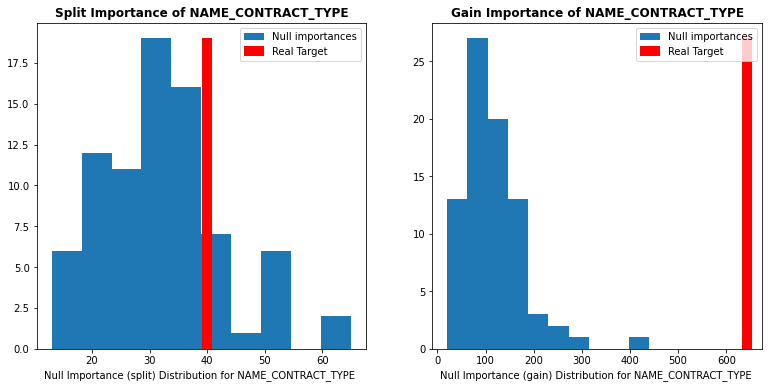

In [194]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='NAME_CONTRACT_TYPE')

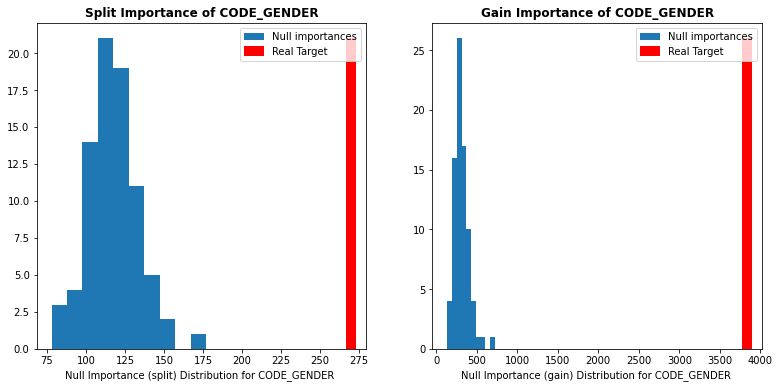

In [195]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CODE_GENDER')

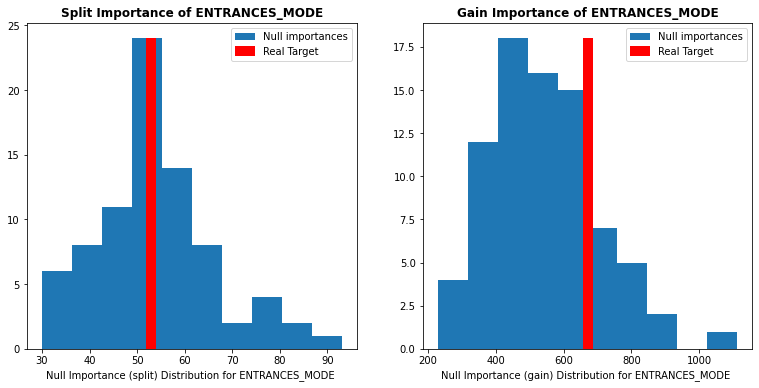

In [196]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='ENTRANCES_MODE')

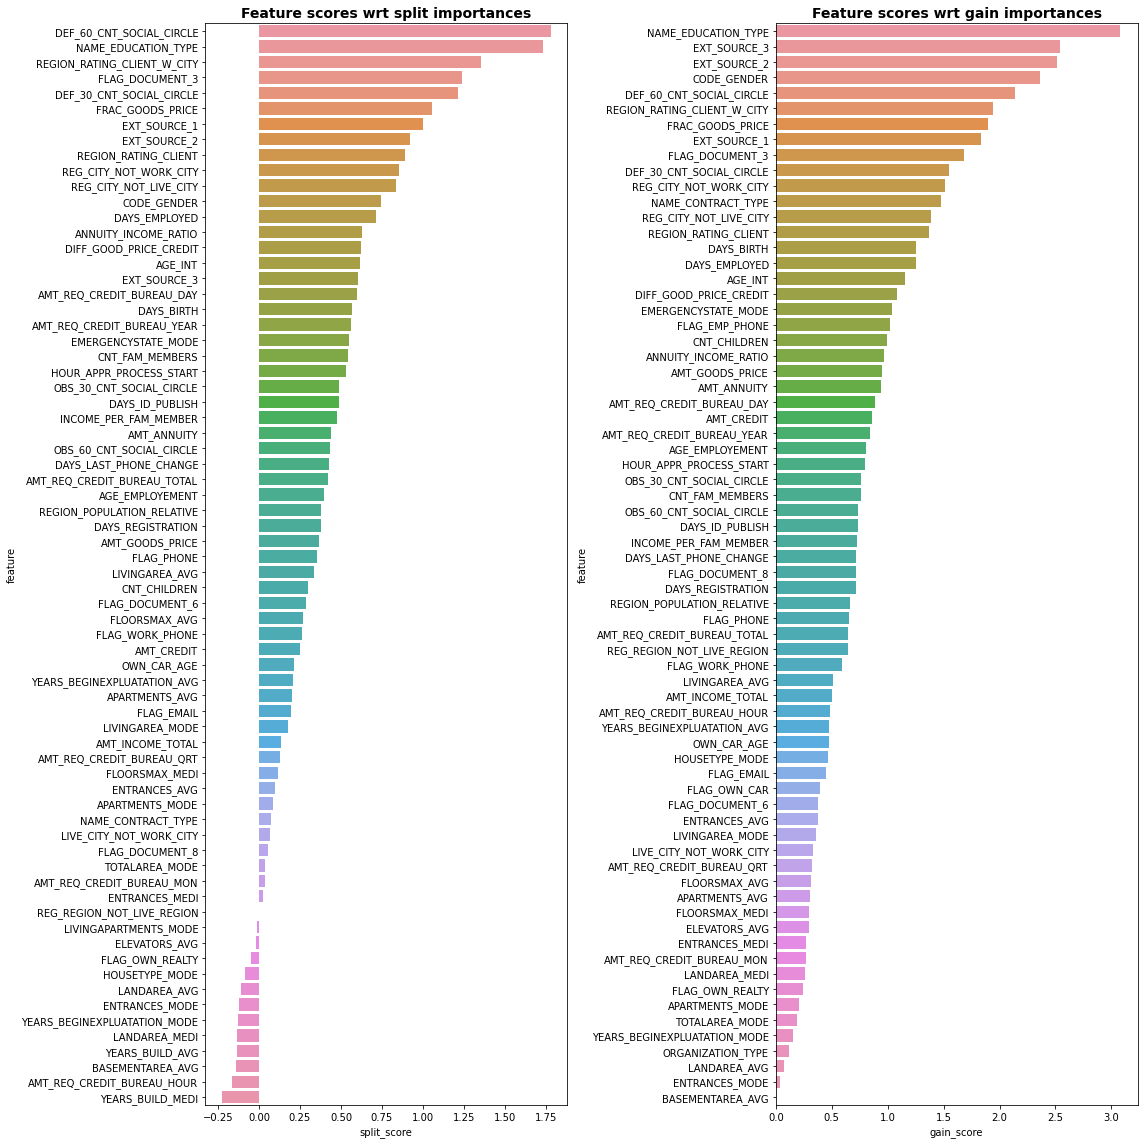

In [197]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

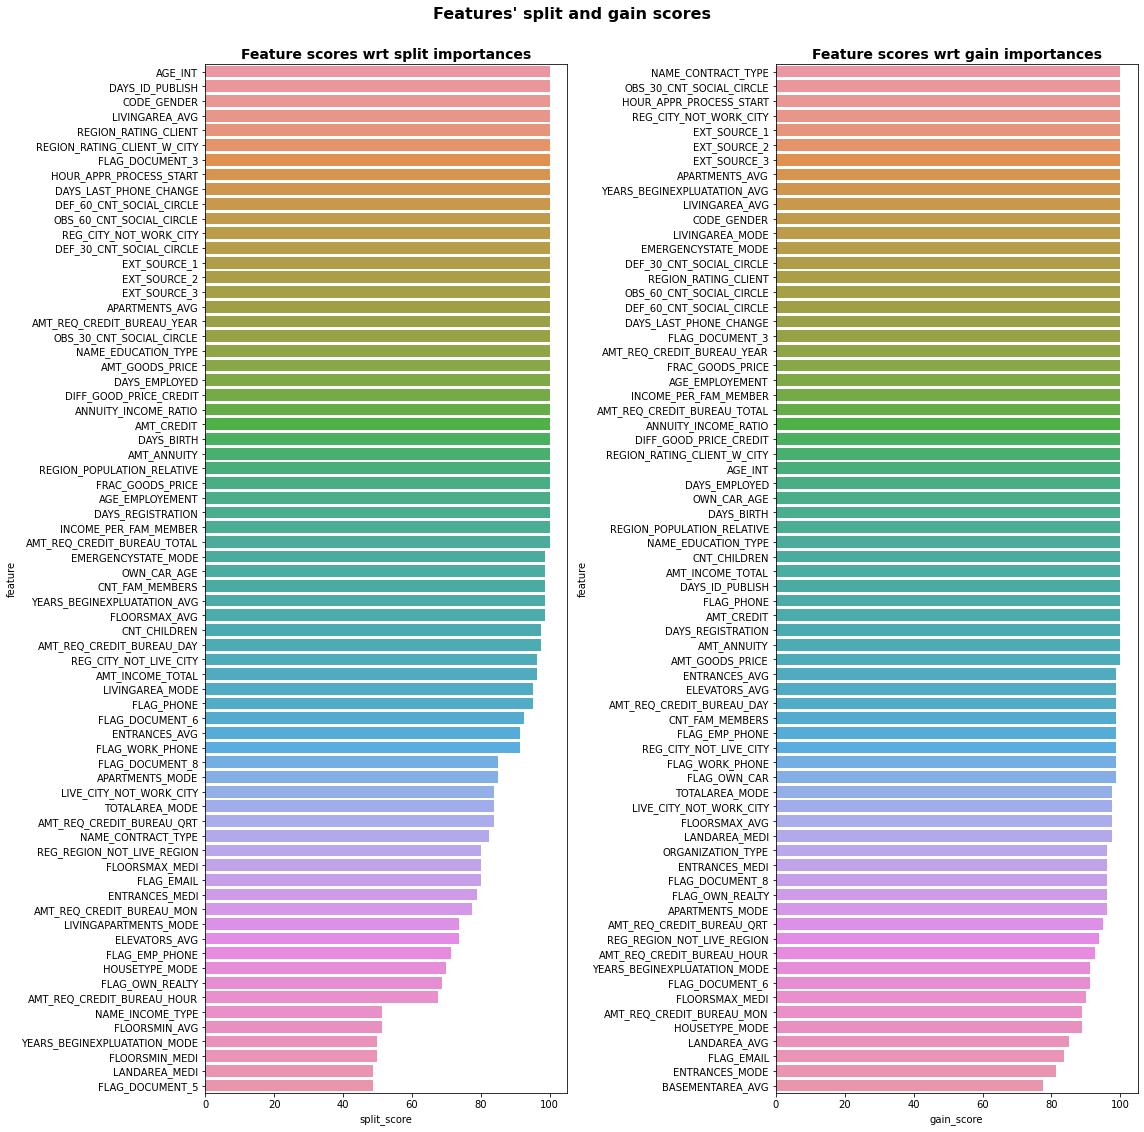

In [198]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [199]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc',
        'verbose':-1
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['TARGET'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['TARGET'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
	 SPLIT : 0.733240 +/- 0.006986
	 GAIN  : 0.733240 +/- 0.006986
Results for threshold  10
	 SPLIT : 0.738516 +/- 0.005744
	 GAIN  : 0.734110 +/- 0.005568
Results for threshold  20
	 SPLIT : 0.737693 +/- 0.004908
	 GAIN  : 0.735573 +/- 0.007509
Results for threshold  30
	 SPLIT : 0.736956 +/- 0.004092
	 GAIN  : 0.733021 +/- 0.006711
Results for threshold  40
	 SPLIT : 0.736466 +/- 0.006879
	 GAIN  : 0.734342 +/- 0.006392
Results for threshold  50
	 SPLIT : 0.739313 +/- 0.003871
	 GAIN  : 0.734354 +/- 0.008105
Results for threshold  60
	 SPLIT : 0.738510 +/- 0.007365
	 GAIN  : 0.737206 +/- 0.006028
Results for threshold  70
	 SPLIT : 0.739342 +/- 0.006583
	 GAIN  : 0.736431 +/- 0.008271
Results for threshold  80
	 SPLIT : 0.741381 +/- 0.006889
	 GAIN  : 0.731678 +/- 0.006718
Results for threshold  90
	 SPLIT : 0.736172 +/- 0.008641
	 GAIN  : 0.735934 +/- 0.005771
Results for threshold  95
	 SPLIT : 0.738350 +/- 0.009780
	 GAIN  : 0.737370 +/- 0.006966
Results fo

In [245]:
threshold = 95
selected_cols = [_f for _f, _, _score in correlation_scores if _score >= threshold]

In [246]:
selected_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_EDUCATION_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'ENTRANCES_MEDI',
 'LANDAREA_MEDI',
 'TOTALAREA_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHO

### Préparation des données <a class="anchor" id="models_prepare_impute"></a> [⇪](#menu)

In [247]:
X_full_s = data_work2[selected_cols].copy()
Y_full_s = data_work2['TARGET']

In [248]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
                                                X_full_s, 
                                                Y_full_s, 
                                                test_size=0.15,
                                                random_state=0,
                                                stratify=Y_full)

In [249]:
print(f"X_train: {X_train_s.shape[0] / X_full_s.shape[0] * 100}% | X_test: {X_test_s.shape[0] / X_full_s.shape[0]* 100}%")

X_train: 85.0% | X_test: 15.0%


In [250]:
oe_model_s, ohe_model_s = fit_labels(X_train_s)

In [251]:
ohe_model_s.feature_names_in_

array(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'ORGANIZATION_TYPE', 'EMERGENCYSTATE_MODE'],
      dtype=object)

In [252]:
X_train_s = transform_labels(X_train_s, oe_model_s, ohe_model_s)
X_test_s = transform_labels(X_test_s, oe_model_s, ohe_model_s)

In [253]:
imputer_model_s = fit_imputer(X_train_s, X_train_s.select_dtypes(include='number').columns)

In [254]:
X_train_s = impute(X_train_s, imputer_model_s)
X_test_s = impute(X_test_s, imputer_model_s)

In [255]:
model_scaler_s = fit_normalizer(X_train_s)

In [256]:
X_train_s = normalize(X_train_s, model_scaler_s)
X_test_s = normalize(X_test_s, model_scaler_s)

In [257]:
X_train_s.shape

(25500, 122)

## 1. Logistic Regression <a class="anchor" id="models_linear_new_features"></a> [⇪](#menu)

In [258]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
    {
        'class_weight':['balanced'],
        'random_state':[0],
        'max_iter':[3000],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    },
]

In [259]:
model_name = "Balanced LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    X_ref=X_train_s,
    y_ref=y_train,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6733
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6096
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6147
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6349
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6756

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6416 (std:0.0587)

----------------------------------------------------------------------------------------------------


In [260]:
grd_log['grid'].best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/features & selection_champ] -------------------------------------

             ROC_AUC : 0.7326
                  F1 : 0.2424
            ACCURACY : 0.6778
           PRECISION : 0.1493
              RECALL : 0.6444
   AVERAGE_PRECISION : 0.2057

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.68      0.80      4140
Prediction = 1       0.15      0.64      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

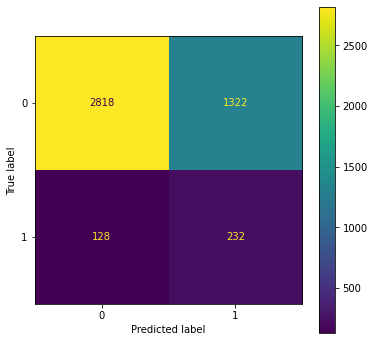

--- ROC AUC ---------------------------------------------------------------------------------------- 



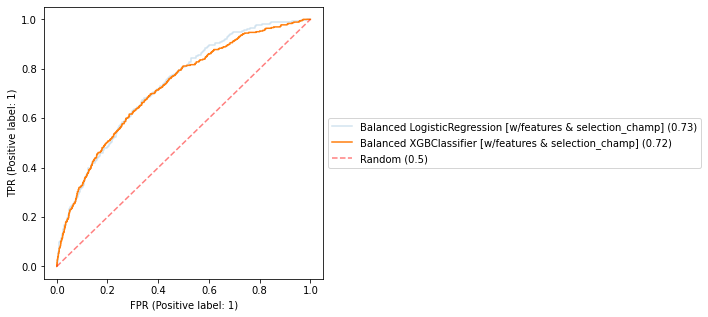

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



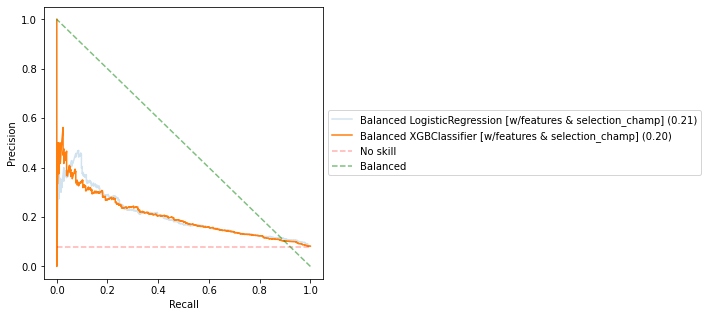

In [261]:
get_scores(f"{model_name} [w/features & selection_champ]", **grd_log, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [262]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train_s, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2718676122931442) for this model is reached with a threshold of 0.534


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/thresholding & features & selection_champ] ----------------------

             ROC_AUC : 0.7326
                  F1 : 0.2490
            ACCURACY : 0.7104
           PRECISION : 0.1571
              RECALL : 0.6000
   AVERAGE_PRECISION : 0.2057

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.72      0.82      4140
Prediction = 1       0.16      0.60      0.25       360

      accuracy                           0.71      4500
     macro avg       0.56      0.66      0.53      4500
  weighted avg       0.89  

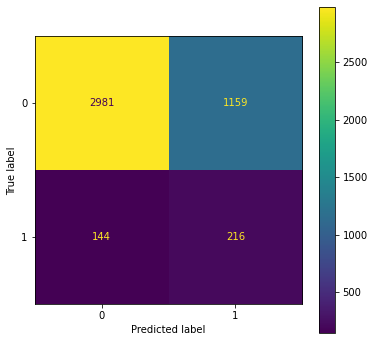

In [263]:
get_scores(f"{model_name} [w/thresholding & features & selection_champ]", **grd_log, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

## 2. Balanced XGBoost Classifier Grid + extra features<a class="anchor" id="models_xgboost_new_features"></a> [⇪](#menu)

In [264]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [265]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[0],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [266]:
model_name = "Balanced XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    X_ref=X_train_s,
    y_ref=y_train,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6931
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6672
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7107
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6544
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6571

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6765 (std:0.0385)

----------------------------------------------------------------------------------------------------


In [267]:
grd_xgb['grid'].best_params_

{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 60,
 'nthread': -1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 11.481644640234949,
 'seed': 0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/features & selection_champ] ------------------------------------------

             ROC_AUC : 0.7226
                  F1 : 0.2415
            ACCURACY : 0.6720
           PRECISION : 0.1482
              RECALL : 0.6528
   AVERAGE_PRECISION : 0.2033

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.67      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.67      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

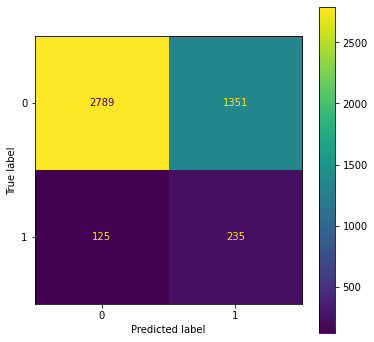

--- ROC AUC ---------------------------------------------------------------------------------------- 



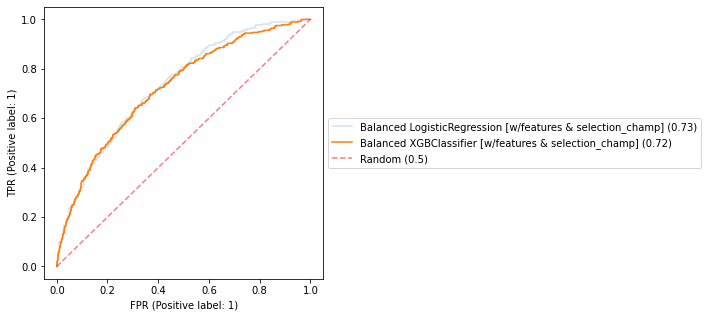

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



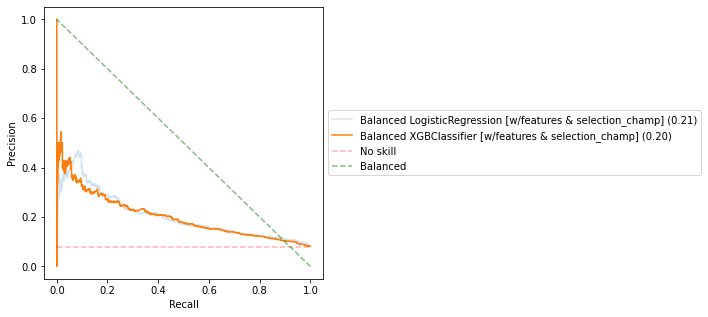

In [268]:
get_scores(f"{model_name} [w/features & selection_champ]", **grd_xgb, X_ref=X_test_s, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [269]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train_s, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2712273641851107) for this model is reached with a threshold of 0.513


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/thresholding & features & selection_champ] ---------------------------

             ROC_AUC : 0.7226
                  F1 : 0.2439
            ACCURACY : 0.6956
           PRECISION : 0.1522
              RECALL : 0.6139
   AVERAGE_PRECISION : 0.2033

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.70      0.81      4140
Prediction = 1       0.15      0.61      0.24       360

      accuracy                           0.70      4500
     macro avg       0.55      0.66      0.53      4500
  weighted avg       0.89  

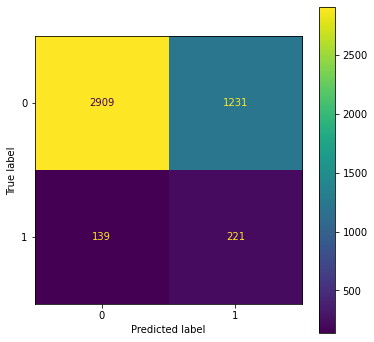

In [270]:
get_scores(f"{model_name} [w/thresholding & features & selection_champ]", **grd_xgb, threshold=best_threshold, X_ref=X_test_s, register=True, show_roccurves=False)

## 3. Revue des scores <a class="anchor" id="models_new_features_scores"></a> [⇪](#menu)

In [271]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
0,Balanced LogisticRegression [w/features & sele...,0.732609,0.242424,0.149292,0.644444
2,Balanced XGBClassifier [w/features & selection...,0.722596,0.241521,0.148172,0.652778


In [272]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Precision', 'Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
1,Balanced LogisticRegression [w/thresholding & ...,0.732609,0.248991,0.157091,0.600000
3,Balanced XGBClassifier [w/thresholding & featu...,0.722596,0.243929,0.152204,0.613889


#### A comparer avec les scores obtenus avant les tunings de ce notebook

In [241]:
scores_ref = pd.read_csv('data/scores.csv')
scores_ref[ (scores_ref.Method.str.contains('Balanced LogisticRegression|Balanced XGBClassifier')) ][['Method','ROC AUC', 'F1 score','Precision','Recall']]

,Method,ROC AUC,F1 score,Precision,Recall
21,Balanced LogisticRegression,0.730879,0.243271,0.149491,0.652778
22,Balanced LogisticRegression [w/thresholding],0.730879,0.228700,0.136364,0.708333
27,Balanced XGBClassifier,0.722080,0.244833,0.151277,0.641667
28,Balanced XGBClassifier [w/thresholding],0.722080,0.180033,0.099819,0.916667


In [242]:
import FreeMobileSMS as sms
sms.send()

JupyterScriptCompleted: Jupyter is waiting

Avec AGE_INT variable

In [575]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.731375,0.240330,0.647222
41,Balanced DecisionTreeClassifier [w/features],0.684823,0.230475,0.586111


In [576]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.731375,0.261682,0.544444
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.684823,0.224147,0.611111


Avec DIFF_GOOD_PRICE_CREDIT variable

In [535]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.731383,0.242865,0.650
41,Balanced DecisionTreeClassifier [w/features],0.680082,0.232193,0.575


In [536]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.731383,0.211176,0.808333
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.680082,0.186298,0.861111


Avec ANNUITY_INCOME_RATIO variable

In [509]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.730864,0.243271,0.652778
41,Balanced DecisionTreeClassifier [w/features],0.676623,0.230812,0.572222


In [510]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.730864,0.228802,0.708333
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.676623,0.208843,0.616667


Avec AMT_REQ_CREDIT_BUREAU_TOTAL variable

In [469]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.731785,0.239589,0.647222
41,Balanced DecisionTreeClassifier [w/features],0.671176,0.231193,0.525000


In [470]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.731785,0.268100,0.519444
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.671176,0.213909,0.563889


Avec INCOME_PER_FAM_MEMBER variable

In [443]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.733038,0.244686,0.655556
41,Balanced DecisionTreeClassifier [w/features],0.681177,0.230042,0.608333


In [444]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.733038,0.224087,0.741667
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.681177,0.173777,0.927778


Avec AGE_EMPLOYEMENT variable

In [417]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.733024,0.244686,0.655556
41,Balanced DecisionTreeClassifier [w/features],0.684947,0.235028,0.577778


In [418]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.733024,0.224087,0.741667
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.684947,0.235028,0.577778


Avec FRAC_GOODS_PRICE variable

In [391]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.731791,0.243877,0.650000
41,Balanced DecisionTreeClassifier [w/features],0.633082,0.188348,0.655556


In [392]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.731791,0.227723,0.702778
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.633082,0.188348,0.655556


Avec toutes les variables

In [295]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.734813,0.236815,0.636111
41,Balanced DecisionTreeClassifier [w/features],0.680082,0.232193,0.575000
43,Balanced RandomForestClassifier [w/features],0.714530,0.247359,0.552778
45,Balanced XGBClassifier [w/features],0.703902,0.230080,0.641667


In [296]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.734813,0.260591,0.563889
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.680082,0.186298,0.861111
44,Balanced RandomForestClassifier [w/thresholdin...,0.714530,0.235294,0.677778
46,Balanced XGBClassifier [w/thresholding & featu...,0.703902,0.238741,0.611111


Avec AUCUNE variable

In [665]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.733060,0.244686,0.655556
41,Balanced DecisionTreeClassifier [w/features],0.694339,0.226686,0.658333


In [666]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.733060,0.224087,0.741667
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.694339,0.237126,0.550000


In [625]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.733060,0.244686,0.655556
41,Balanced DecisionTreeClassifier [w/features],0.675733,0.235903,0.569444


In [626]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.733060,0.224087,0.741667
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.675733,0.235903,0.569444


In [600]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.73306,0.244686,0.655556
41,Balanced DecisionTreeClassifier [w/features],0.63514,0.208536,0.536111


In [601]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.73306,0.224087,0.741667
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.63514,0.174102,0.780556


In [340]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
39,Balanced LogisticRegression [w/features],0.733060,0.244686,0.655556
41,Balanced DecisionTreeClassifier [w/features],0.680082,0.232193,0.575000


In [341]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('features')) ][['Method','ROC AUC', 'F1 score','Recall']][:2]

,Method,ROC AUC,F1 score,Recall
40,Balanced LogisticRegression [w/thresholding & ...,0.733060,0.224087,0.741667
42,Balanced DecisionTreeClassifier [w/thresholdin...,0.680082,0.186298,0.861111


In [297]:
sms.send()

JupyterScriptCompleted: Jupyter is waiting

# Custom metric <a class="anchor" id="custom_metric"></a> [⇪](#menu)

## 1. The problem <a class="anchor" id="custom_metric_problem"></a> [⇪](#menu)

>#### Let's interpret the four correlation matrix values in regards to this project:
> - `(TP) True Positive` : the client is predicted as NOT OK and it really is NOT OK. *(we **save** money)*
> - `(TN) True Negative` : the client is predicted as OK and it really is OK. *(we **earn** money)*
> - `(FP) False Positive` : the client is predicted as OK but it is in fact NOT OK. *(we **miss** money)*
> - `(FN) False Negative` : the client is predicted as NOT OK but it is in fact OK. *(we **lose** money)*
>
>#### So the goals in order of importance are:
> 1. minimize the `(FN) False Negative` to **avoid losing money**.
> 2. maximize the `(TN) True Negative` to **earn money**.
> 3. maximize the `(TP) True Positive` to save money.
> 4. minimize the `(FP) False Positive` to avoid missing money.

>#### Currently we are using the F1-measure and the ROC-AUC score.
>
> - The `F1-Measure` **balance the weight** on PRECISION and RECALL.
> - The `ROC AUC score`  summarize the **trade-off** between the true positive rate (RECALL) and false positive rate (ANTI-SPECIFICITY).
>

> RECALL = $\frac{TP}{TP + FN}$
> - High RECALL favors TP over FN
> - Low RECALL favors FN over TP

> PRECISION = $\frac{TP}{TP + FP}$
> - High PRECISION favors TP over FP
> - Low PRECISION favors FP over TP

> ANTI-SPECIFICITY = 1 - SPECIFICITY = 1 - $\frac{TN}{TN + FS}$ = $\frac{FP}{FP + TN}$
> - High ANTI-SPECIFICITY favors FP over TN
> - Low ANTI-SPECIFICITY favors TN over FP

## 2. F-measure <a class="anchor" id="custom_metric_solution"></a> [⇪](#menu)

> * `F0.5-Measure`: **More weight on precision**, less weight on recall.
> * `F1-Measure`  : **Balance the weight** on precision and recall.
> * `F2-Measure`  : **More weight on recall**, less weight on precision.

>#### And luckily, there exists a [Fbeta-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) function in sklearn, which can be used to reproduce those F-measure and any in between measure... So we can in fact decide how much weight we want to give to RECALL.

>#### We want to maximize this `Fbeta-score` with beta > 1.0 !

In [ ]:
from sklearn.metrics import fbeta_score
fb_score = fbeta_score(y_test, y_pred_log, beta=2.0)
fb_score

In [ ]:
import FreeMobileSMS as sms
sms.send()

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
def my_loss(xvals, yvals, validation=False):
    print(xvals.index, yvals, validation)
    return 1.0

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
grd_dt = fit_model(
    DecisionTreeClassifier(), 
    param_grid={ 'random_state':[0] }, 
    cv = skfold,
    scoring="custom"
)

In [ ]:
get_scores(f"Basic {get_model_name(grd_dt['model'])}", **grd_dt, register=True)